<a href="https://colab.research.google.com/github/joshuabusinge/deeplearning_chestopacity/blob/main/ChestOpacity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### IMPORT LIBRARIES

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#### MOUNT GOOGLE DRIVE

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#import pathlib
dataset_1 = "/content/drive/MyDrive/MASTERS DEGREE/Makerere Unversity/SEM 2/Deep Learning/dataset1"
training_ds = tf.keras.utils.image_dataset_from_directory(dataset_1, validation_split=0.2, 
                                                          subset="training", seed=123, image_size=(100, 100), batch_size=20)
# data_dir = pathlib.Path(dataset_1)

Found 715 files belonging to 2 classes.
Using 572 files for training.


In [4]:
class_names = training_ds.class_names
print(class_names)

['normal', 'sick']


In [5]:
valid_ds = tf.keras.utils.image_dataset_from_directory(dataset_1, validation_split=0.2, subset="validation", seed=123, image_size=(100, 100), batch_size=20)


Found 715 files belonging to 2 classes.
Using 143 files for validation.


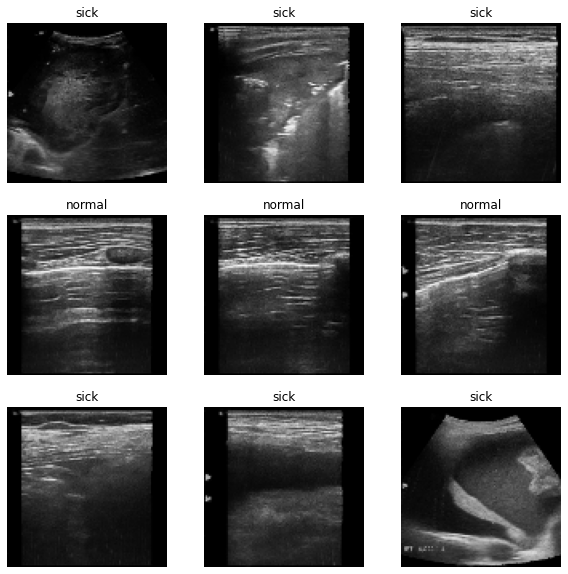

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in training_ds:
  print(image_batch.shape)
  
  break

(20, 100, 100, 3)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

training_ds = training_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
# Normalize pixel values to be between 0 and 1
normalization_layer = layers.Rescaling(1./255)

In [10]:
normalized_ds = training_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[3]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 


0.0 0.9768686


Creating the CNN Model for prediction

In [11]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(100, 100, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(), 
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes),
  #layers.Dense(num_classes, activation = 'softmax')
])



Compile the Model

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model Summary

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        1

Train the Model

In [14]:
epochs=10
history = model.fit(
  training_ds,
  validation_data=valid_ds,
  epochs=epochs
)

Epoch 1/10
29/29 [==============================] - 47s 1s/step - loss: 0.4518 - accuracy: 0.7762 - val_loss: 0.2103 - val_accuracy: 0.9161
Epoch 2/10
29/29 [==============================] - 0s 9ms/step - loss: 0.1749 - accuracy: 0.9283 - val_loss: 0.1438 - val_accuracy: 0.9580
Epoch 3/10
29/29 [==============================] - 0s 8ms/step - loss: 0.1067 - accuracy: 0.9615 - val_loss: 0.1019 - val_accuracy: 0.9720
Epoch 4/10
29/29 [==============================] - 0s 8ms/step - loss: 0.0532 - accuracy: 0.9843 - val_loss: 0.0904 - val_accuracy: 0.9720
Epoch 5/10
29/29 [==============================] - 0s 7ms/step - loss: 0.0412 - accuracy: 0.9825 - val_loss: 0.1314 - val_accuracy: 0.9301
Epoch 6/10
29/29 [==============================] - 0s 7ms/step - loss: 0.0348 - accuracy: 0.9895 - val_loss: 0.0899 - val_accuracy: 0.9580
Epoch 7/10
29/29 [==============================] - 0s 7ms/step - loss: 0.0152 - accuracy: 0.9965 - val_loss: 0.0648 - val_accuracy: 0.9650
Epoch 8/10
29/29 [==

Visualize training results

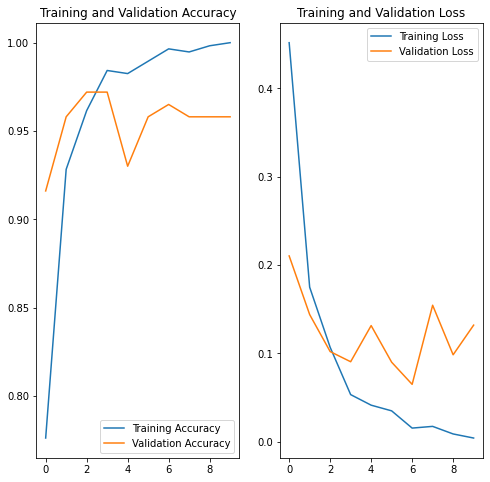

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
valid_loss,valid_acc = model.evaluate(valid_ds)
print(valid_loss)
print(valid_acc)

training_loss,training_acc = model.evaluate(training_ds)
print(training_loss)
print(training_acc)


8/8 [==============================] - 0s 4ms/step - loss: 0.1319 - accuracy: 0.9580
0.13185769319534302
0.9580419659614563
29/29 [==============================] - 0s 4ms/step - loss: 0.0019 - accuracy: 1.0000
0.001862727920524776
1.0


Data augmentation

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(100,
                                  100,
                                  3)),
    layers.RandomRotation(0.0),
    layers.RandomZoom(0.3),
  ]
)

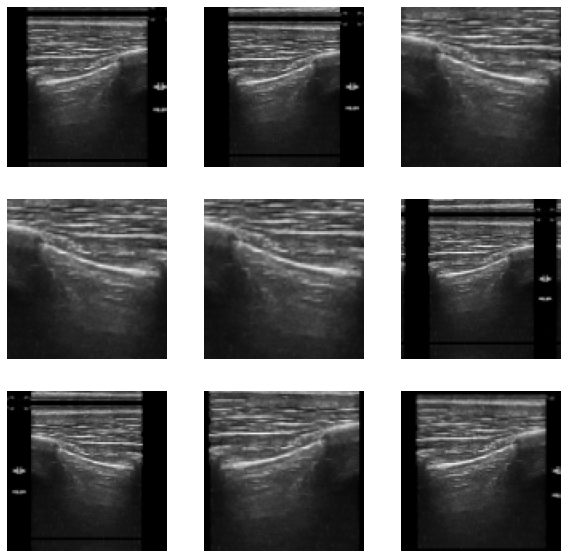

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in training_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Dropout

In [19]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 100, 100, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                  

In [22]:
epochs = 10
history = model.fit(
  training_ds,
  validation_data=valid_ds,
  epochs=epochs
)

Epoch 1/10
29/29 [==============================] - 1s 15ms/step - loss: 0.5103 - accuracy: 0.7535 - val_loss: 0.3838 - val_accuracy: 0.8601
Epoch 2/10
29/29 [==============================] - 0s 10ms/step - loss: 0.3805 - accuracy: 0.8182 - val_loss: 0.2322 - val_accuracy: 0.9091
Epoch 3/10
29/29 [==============================] - 0s 9ms/step - loss: 0.2930 - accuracy: 0.8654 - val_loss: 0.1830 - val_accuracy: 0.9301
Epoch 4/10
29/29 [==============================] - 0s 9ms/step - loss: 0.2190 - accuracy: 0.9021 - val_loss: 0.3217 - val_accuracy: 0.8671
Epoch 5/10
29/29 [==============================] - 0s 8ms/step - loss: 0.1709 - accuracy: 0.9248 - val_loss: 0.2498 - val_accuracy: 0.9091
Epoch 6/10
29/29 [==============================] - 0s 9ms/step - loss: 0.1846 - accuracy: 0.9126 - val_loss: 0.0716 - val_accuracy: 0.9650
Epoch 7/10
29/29 [==============================] - 0s 8ms/step - loss: 0.1706 - accuracy: 0.9266 - val_loss: 0.0860 - val_accuracy: 0.9720
Epoch 8/10
29/29 [

Visualize training results

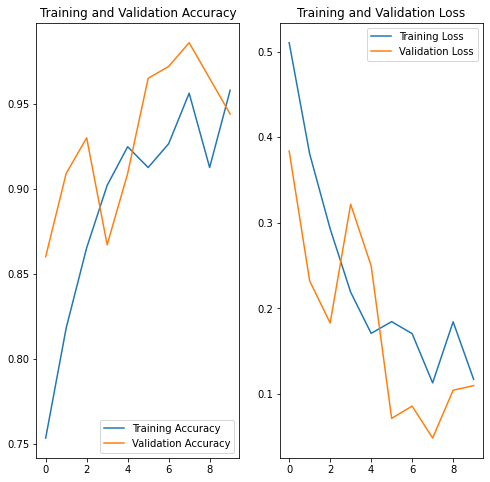

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
valid_loss,valid_acc = model.evaluate(valid_ds)
print(valid_loss)
print(valid_acc)

training_loss,training_acc = model.evaluate(training_ds)
print(training_loss)
print(training_acc)

8/8 [==============================] - 0s 4ms/step - loss: 0.1099 - accuracy: 0.9441
0.10991963744163513
0.9440559148788452
29/29 [==============================] - 0s 4ms/step - loss: 0.0648 - accuracy: 0.9703
0.06477386504411697
0.9702796936035156


Predict on new data

In [25]:
dataset_1 = "/content/drive/MyDrive/MASTERS DEGREE/Makerere Unversity/SEM 2/Deep Learning/dataset1/normal/normal_0.png"
#test_ds = tf.keras.utils.get_file('sick', origin = dataset_1 )

img = tf.keras.utils.load_img(dataset_1, target_size=(100, 100))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to normal with a 99.98 percent confidence.


Found 50 files belonging to 1 classes.
Predictions:
 [0 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0
 0 1 1 1 1 1 1 1 1 0 0 1 1]


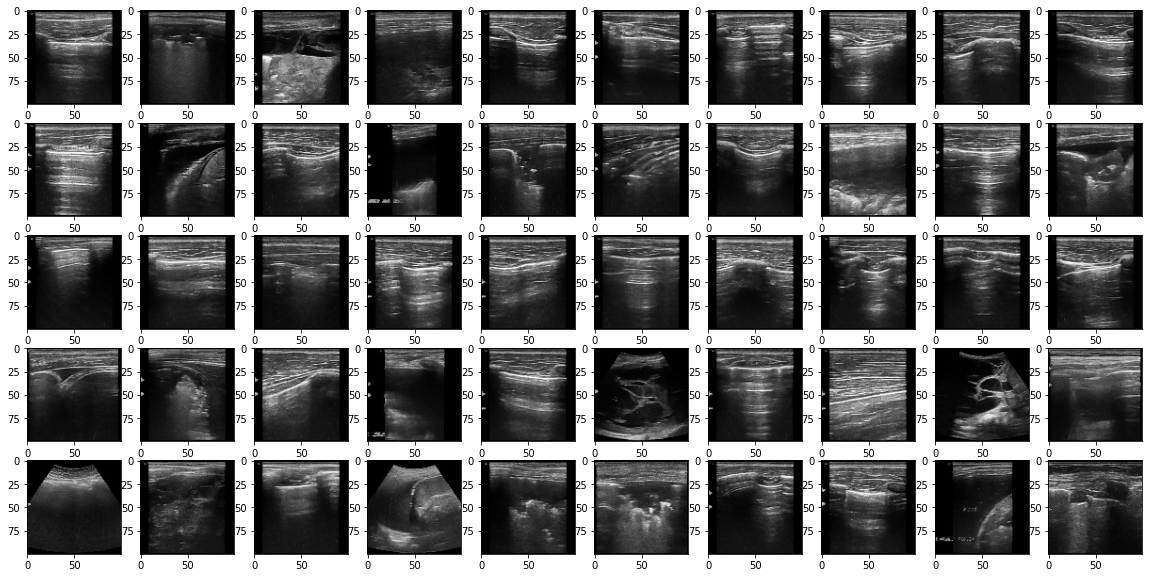

In [26]:
dataset_1 = "/content/drive/MyDrive/MASTERS DEGREE/Makerere Unversity/SEM 2/Deep Learning/unknown_images"
test_ds = tf.keras.utils.image_dataset_from_directory(dataset_1, image_size=(100, 100), batch_size=50)

# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
predictions = tf.math.argmax(predictions,1)
#predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
#print('Labels:\n', label_batch)

plt.figure(figsize=(20, 10))
for i in range(50):
  ax = plt.subplot(5, 10, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  

In [27]:
import pandas as pd
import numpy as np
  
  
# convert array into dataframe
DF = pd.DataFrame(predictions)
  
# save the dataframe as a csv file
DF.to_csv("image_results.csv")

In [28]:
test_loss,test_acc = model.evaluate(test_ds)
print(test_loss)
print(test_acc)

1/1 [==============================] - 0s 180ms/step - loss: 3.1425 - accuracy: 0.5400
3.142488956451416
0.5400000214576721


In [29]:
y_pred = []
y_true = []

for image_batch, label_batch in valid_ds:

  y_true.append(label_batch)

  predictions = model.predict(image_batch)

  y_pred.append(np.argmax(predictions, axis = -1))

correct_labels = tf.concat([item for item in y_true],axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis =0)

from sklearn.metrics._plot.confusion_matrix import confusion_matrix
cm=confusion_matrix(predicted_labels,correct_labels)
print(cm)

[[71  5]
 [ 3 64]]


In [30]:
y_pred = []
y_true = []

for image_batch, label_batch in valid_ds:

  y_true.append(label_batch)

  predictions = model.predict(image_batch)

  y_pred.append(np.argmax(predictions, axis = -1))

correct_labels = tf.concat([item for item in y_true],axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis =0)

from sklearn.metrics._plot.confusion_matrix import confusion_matrix
cm=confusion_matrix(predicted_labels,correct_labels)
print(cm)

[[71  5]
 [ 3 64]]


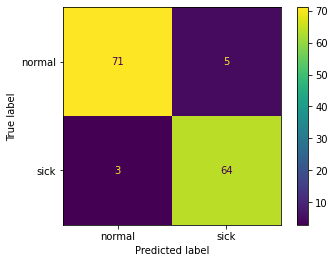

In [31]:
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = class_names)
disp.plot()

plt.show()

In [32]:
from sklearn.metrics import classification_report
print(classification_report(predicted_labels,correct_labels))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95        76
           1       0.93      0.96      0.94        67

    accuracy                           0.94       143
   macro avg       0.94      0.94      0.94       143
weighted avg       0.94      0.94      0.94       143



Predict New Data from DataSet_2

In [33]:
dataset_2 = "/content/drive/MyDrive/MASTERS DEGREE/Makerere Unversity/SEM 2/Deep Learning/dataset2"
test_ds2 = tf.keras.utils.image_dataset_from_directory(dataset_2, image_size=(100, 100), batch_size=50)

Found 224 files belonging to 1 classes.


In [34]:
AUTOTUNE = tf.data.AUTOTUNE

test_ds2 = test_ds2.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [35]:
normalization_layer = layers.Rescaling(1./255)

In [36]:
normalized_ds2 = test_ds2.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds2))
first_image = image_batch[3]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.8169845


Predictions Dataset2:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


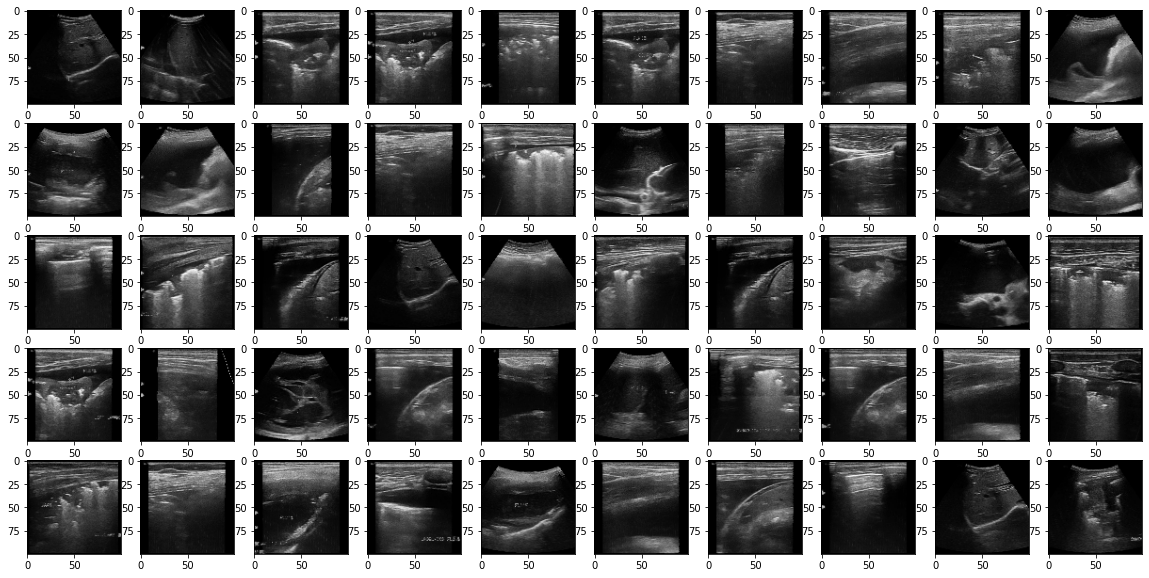

In [37]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds2.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
predictions_ds2 = tf.math.argmax(predictions,1)
#predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions Dataset2:\n', predictions_ds2.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(20, 10))
for i in range(50):
  ax = plt.subplot(5, 10, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))

In [38]:
# convert array into dataframe
DF = pd.DataFrame(predictions)
  
# save the dataframe as a csv file
DF.to_csv("image_results_ds2.csv")

In [39]:
test_loss,test_acc = model.evaluate(test_ds2)
print(test_loss)
print(test_acc)

5/5 [==============================] - 0s 8ms/step - loss: 6.2700 - accuracy: 0.0893
6.269996166229248
0.0892857164144516
